In [238]:
"""
Koden henter laksedata fra SSB og gjør dataen om til en tabell for alle verdiene som brukes videre i prosjektet ved hjelp av Pandas.
"""

import requests
import pandas as pd
from itertools import product

# URL til SSB API for tabell 03024
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    """Henter data fra SSB API og returnerer JSON-responsen."""
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    response = requests.post(api_url, json=query)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Feil ved henting av data: {response.status_code}\n{response.text}")

def process_data(data):
    """Prosesserer JSON-data og returnerer en formatert Pandas DataFrame."""
    dimension_names = list(data["dimension"].keys())
    values = data["value"]

    # Kombinasjoner av dimensjoner
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))

    # Lag DataFrame og knytt til verdiene
    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values

    # Pivotér data
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["Tid", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]

    # Del opp "Tid" i År og Uke
    df_pivot["År"] = df_pivot["Tid"].str[:4].astype(int)
    df_pivot["Uke"] = df_pivot["Tid"].str[5:].astype(int)
   


    # Fjern "Tid" og omorganiser kolonner slik at År og Uke kommer først
    df_pivot = df_pivot.drop(columns=["Tid"])
    kolonnerekkefølge = ["År", "Uke"] + [col for col in df_pivot.columns if col not in ["År", "Uke"]]
    df_pivot = df_pivot[kolonnerekkefølge]

    # Lag en uke-dato-kolonne for plotting (mandag i hver uke)
    df_pivot["UkeDato"] = pd.to_datetime(df_pivot["År"].astype(str) + "-" + df_pivot["Uke"].astype(str).str.zfill(2) + "-1", format="%Y-%W-%w")


    return df_pivot



def main(): #henter main og behandler dataen og returnerer df_pivot
    try:
        data = fetch_data()
        df_pivot = process_data(data)
        return df_pivot  # returnerer dataene fra main()
    except Exception as e:
        print(e)
        return None

if __name__ == "__main__":
    df_pivot = main()  # mottar resultatet fra main()
    if df_pivot is not None:
        print(df_pivot.to_string(index=False))  # dataene printes her 



  År  Uke  Fersk laks - Kilospris  Fersk laks - Vekt (tonn)  Frosset laks - Kilospris  Frosset laks - Vekt (tonn)    UkeDato
2000    1                   30.98                    3728.0                     32.54                       383.0 2000-01-03
2000    2                   31.12                    4054.0                     33.63                       216.0 2000-01-10
2000    3                   31.03                    4043.0                     36.06                       633.0 2000-01-17
2000    4                   30.95                    3730.0                     34.27                       393.0 2000-01-24
2000    5                   31.30                    3831.0                     33.91                       453.0 2000-01-31
2000    6                   32.53                    4415.0                     35.30                       265.0 2000-02-07
2000    7                   32.46                    4617.0                     34.49                       344.0 2000-02-14


In [239]:
"""
En samlet oversikt over statistisk analyse av laksedataene fra SSB, som viser gjennomsnitt, median og standardavvik for hver variabel over alle år.
"""

import numpy as np
import pandas as pd

#De ulike kolonnene i datasettet som vi bruker
numeriske_kolonner = [
    "Fersk laks - Kilospris", 
    "Fersk laks - Vekt (tonn)", 
    "Frosset laks - Kilospris", 
    "Frosset laks - Vekt (tonn)"
]

#Regner ut statistikken for alle årene til sammen
samlet_statistikk = []

for kol in numeriske_kolonner:
    verdier = df_pivot[kol].dropna()
    samlet_statistikk.append({
        "Variabel": kol,
        "Gjennomsnitt": round(np.mean(verdier), 2),
        "Median": round(np.median(verdier), 2),
        "Standardavvik": round(np.std(verdier), 2)
    })


df_samlet_statistikk = pd.DataFrame(samlet_statistikk)
df_samlet_statistikk.set_index("Variabel", inplace=True)

#visualieres med en tabell som kan scrolle, bruker derfor HTML
from IPython.display import display, HTML

display(HTML(f"""
<div style="width:60%; padding:8px; border:1px solid #ddd; overflow:auto;">
{df_samlet_statistikk.to_html()}
</div>
"""))


,Gjennomsnitt,Median,Standardavvik
Variabel,,,
Fersk laks - Kilospris,45.55,37.94,23.12
Fersk laks - Vekt (tonn),13065.61,13615.50,5762.24
Frosset laks - Kilospris,45.98,40.68,20.77
Frosset laks - Vekt (tonn),625.02,564.00,309.08


Denne tabellen gir en total oversikt over statistikken for alle 4 variablene. Man kan fort se om disse verdiene viker ekstremt fra de originale verdiene og kan følge med på disse.
Vekten til fersk laks har større variasjon enn frosset laks sin vekt har, men dette kan også skyldes at det generelt sett eksporteres mindre i forhold.

/var/folders/tm/w7fw79pn5hl46tszbnqf54840000gn/T/ipykernel_15587/2469737318.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x="Kategori", y="Kilospris", palette=["limegreen", "red"])


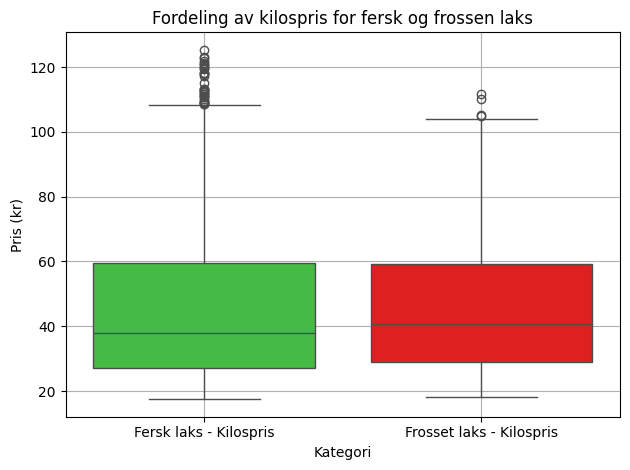

'\n    median vises av streken i midten av boksen \n    standardavvik vises av den laveste streken i diagrammet \n    gjennomsnittet vises av \n    prikkene helt øverst viser uteliggere og ekstreme verdier\n\n\n    MÅ TENKE PÅ OM DETTE SKAL FLYTTES TIL OPPGAVETEKSTEN.skal endres på.\nBoksplottet visualiserer sentrale statistiske mål som median og kvartiler. \nGjennomsnitt er ikke inkludert automatisk i plottet, men kan legges til. \nI dette tilfellet er gjennomsnittet nær medianen, noe som indikerer en jevn fordeling, særlig for frosset laks.\n\n '

In [240]:
"""
Det kommer to bokser som viser fordelingen for kiloprisen av fersk og frossen laks.
Man kan her se om prisen er stabil eller om det er store prisfroskjeller.
Viser boxplot over ukentlig kilopris for fersk og frossen laks.

"""


import seaborn as sns
import matplotlib.pyplot as plt

# Lag "long" format for enklere plotting
df_long = df_pivot[[
    "Fersk laks - Kilospris", 
    "Frosset laks - Kilospris"
]].melt(var_name="Kategori", value_name="Kilospris")

sns.boxplot(data=df_long, x="Kategori", y="Kilospris", palette=["limegreen", "red"])
plt.title("Fordeling av kilospris for fersk og frossen laks")
plt.ylabel("Pris (kr)")
plt.grid(True)
plt.tight_layout()
plt.show()

"""
    median vises av streken i midten av boksen 
    standardavvik vises av den laveste streken i diagrammet 
    gjennomsnittet vises av 
    prikkene helt øverst viser uteliggere og ekstreme verdier

    
    MÅ TENKE PÅ OM DETTE SKAL FLYTTES TIL OPPGAVETEKSTEN.skal endres på.
Boksplottet visualiserer sentrale statistiske mål som median og kvartiler. 
Gjennomsnitt er ikke inkludert automatisk i plottet, men kan legges til. 
I dette tilfellet er gjennomsnittet nær medianen, noe som indikerer en jevn fordeling, særlig for frosset laks.

 """


/var/folders/tm/w7fw79pn5hl46tszbnqf54840000gn/T/ipykernel_15587/461653907.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


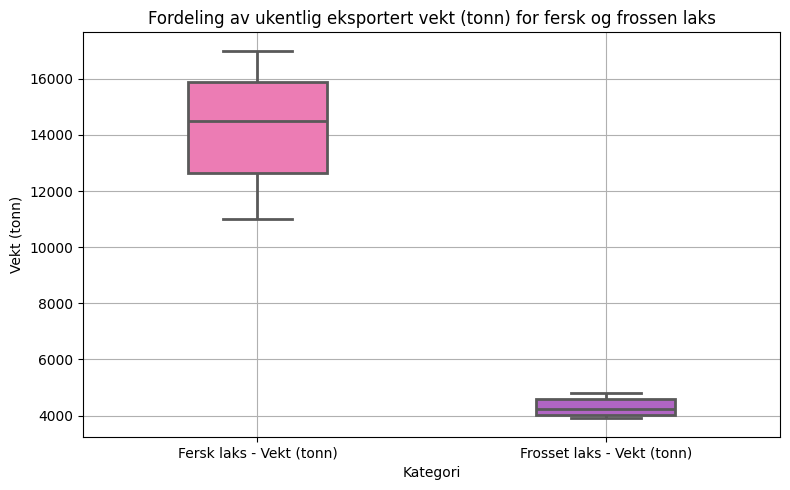

'\n    Her var det ingen uteliggere er det en feil? hvis ikke er det et godt tegn på at det ikke er store variasjoner i vekten av laksen som eksporteres.\n\n'

In [241]:
"""
Boxplottet viser tydelig at fersk laks har et høyere og mer variert eksportvolum per uke enn frossen laks. 
Medianen ligger høyere, og boksen er bredere noe som indikerer større variasjon i vekten.
Det er også flere uteliggere i den ferske kategorien, noe som kan skyldes høysesonger eller spesielle eksporttopper.
"""


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Eksempeldata for boksplott over vekter – simulerer df_pivot med vektverdier
# I faktisk bruk skal dette være din df_pivot med "Fersk laks - Vekt (tonn)" og "Frosset laks - Vekt (tonn)"
# Her bruker vi dummydata bare for visuell demonstrasjon
data = {
    "Fersk laks - Vekt (tonn)": [12000, 13000, 15000, 11000, 16000, 17000, 12500, 14000, 15500, 16500],
    "Frosset laks - Vekt (tonn)": [4000, 4500, 4800, 4300, 4100, 3900, 4700, 4600, 4200, 4000]
}
df_pivot_sim = pd.DataFrame(data)

# Gjør dataen "long" for bruk i seaborn
df_long_vekt = df_pivot_sim[[
    "Fersk laks - Vekt (tonn)", 
    "Frosset laks - Vekt (tonn)"
]].melt(var_name="Kategori", value_name="Vekt (tonn)")

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_long_vekt, 
    x="Kategori", 
    y="Vekt (tonn)",
    width=0.4,
    showfliers=True,
    linewidth=2.0,
    palette=["hotpink", "mediumorchid"]  # oransje og lys blå
)




plt.title("Fordeling av ukentlig eksportert vekt (tonn) for fersk og frossen laks")
plt.grid(True)
plt.tight_layout()
plt.show()


"""
    Her var det ingen uteliggere er det en feil? hvis ikke er det et godt tegn på at det ikke er store variasjoner i vekten av laksen som eksporteres.
    
"""


In [242]:
from IPython.display import display, HTML
import numpy as np

# Sørg for at du har en 'År'-kolonne i df_pivot
if "År" not in df_pivot.columns:
    df_pivot["År"] = df_pivot["Tid"].str[:4].astype(int)

# Velg numeriske kolonner
numeriske_kolonner = [
    "Fersk laks - Kilospris", 
    "Fersk laks - Vekt (tonn)", 
    "Frosset laks - Kilospris", 
    "Frosset laks - Vekt (tonn)"
]

# Liste for å lagre resultater
statistikk_per_år = []



# Gå gjennom hvert år
for år in sorted(df_pivot["År"].unique()):
    df_år = df_pivot[df_pivot["År"] == år]
    for kol in numeriske_kolonner:
        verdier = df_år[kol].dropna()
        statistikk_per_år.append({
            "År": år,
            "Variabel": kol,
            "Gjennomsnitt": round(np.mean(verdier), 2),
            "Median": round(np.median(verdier), 2),
            "Standardavvik": round(np.std(verdier), 2)
        })


df_stat_år = pd.DataFrame(statistikk_per_år)  #Lager selve dataframen med statistikken før bruk av pivot table til å organisere dataene



# Bruk pivot_table for å gjøre det oversiktlig
pivot = df_stat_år.pivot_table(
    index="År", 
    columns="Variabel", 
    values=["Gjennomsnitt", "Median", "Standardavvik"]
)

# Sorter kolonne-nivåene for penere utskrift
pivot = pivot.sort_index(axis=1, level=0)



for mål in ["Gjennomsnitt", "Median", "Standardavvik"]:
    print(f"\n🔹 {mål}")
    visning = df_stat_år.pivot(index="År", columns="Variabel", values=mål).round(2)
    display(HTML(visning.to_html()))




🔹 Gjennomsnitt


Variabel,Fersk laks - Kilospris,Fersk laks - Vekt (tonn),Frosset laks - Kilospris,Frosset laks - Vekt (tonn)
År,,,,
2000,32.04,5085.94,37.44,640.75
2001,25.99,4989.46,26.96,693.83
2002,23.36,5204.48,23.02,725.63
2003,21.24,6033.48,23.65,865.94
2004,22.57,6426.75,24.48,913.55
2005,26.22,7441.08,27.17,786.69
2006,32.41,7721.75,35.80,827.65
2007,26.68,9595.21,27.26,923.63
2008,27.02,9900.13,28.62,740.15



🔹 Median


Variabel,Fersk laks - Kilospris,Fersk laks - Vekt (tonn),Frosset laks - Kilospris,Frosset laks - Vekt (tonn)
År,,,,
2000,32.33,4963.0,37.14,621.0
2001,26.45,4924.0,28.34,661.0
2002,23.38,5126.0,23.80,704.5
2003,21.75,5986.5,23.94,842.0
2004,22.46,6436.0,24.44,950.0
2005,26.04,7130.5,26.65,756.5
2006,30.92,7246.5,34.58,768.0
2007,26.48,9440.5,27.42,910.0
2008,26.81,9701.0,28.24,741.5



🔹 Standardavvik


Variabel,Fersk laks - Kilospris,Fersk laks - Vekt (tonn),Frosset laks - Kilospris,Frosset laks - Vekt (tonn)
År,,,,
2000,3.37,1054.06,3.50,217.63
2001,1.65,980.75,3.86,245.25
2002,0.70,1329.39,2.67,240.21
2003,1.79,1356.60,1.46,273.43
2004,1.35,1577.49,1.47,258.80
2005,1.66,1523.56,2.56,308.43
2006,5.09,1817.05,5.29,341.15
2007,1.85,1912.74,2.02,295.52
2008,1.47,1787.55,2.19,291.58


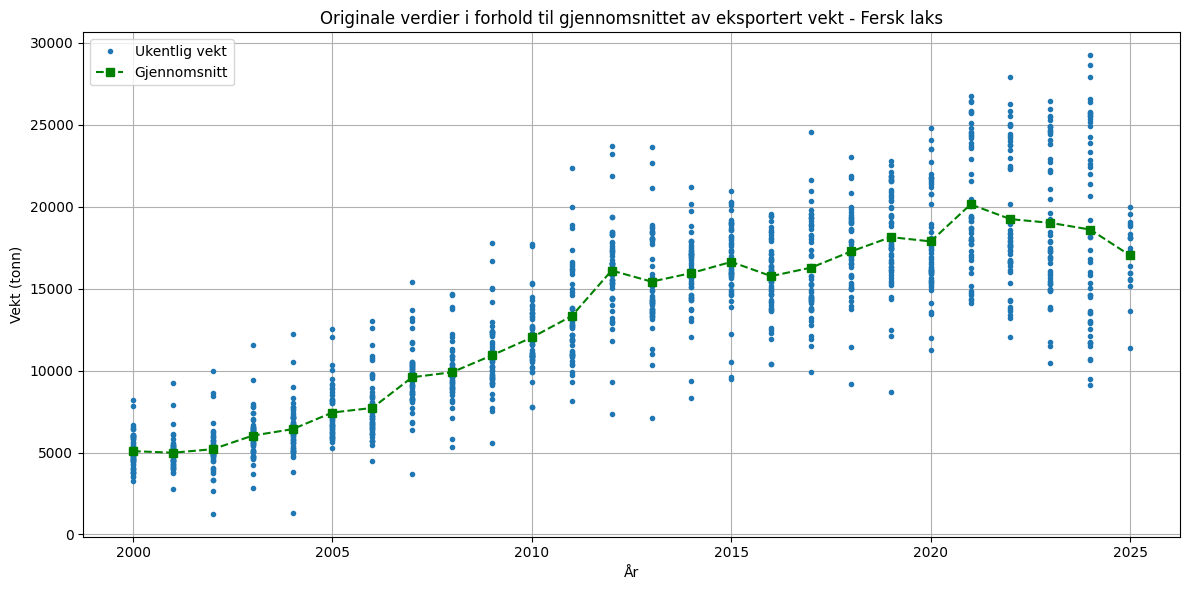

In [ ]:

plt.figure(figsize=(12, 6))

#plotter en graf for årlig vekt 
plt.plot(df_pivot["År"], df_pivot["Fersk laks - Vekt (tonn)"],
         linestyle="None", marker="o", markersize=3, label="Ukentlig vekt")

#Viser en linje over gjennomsnittet av vekten
df_mean = df_pivot.groupby("År")["Fersk laks - Vekt (tonn)"].mean().reset_index()
plt.plot(df_mean["År"], df_mean["Fersk laks - Vekt (tonn)"],
         linestyle="--", color="green", marker="s", label="Gjennomsnitt")

#faktisk plotting 
plt.title("Originale verdier i forhold til gjennomsnittet av eksportert vekt - Fersk laks")
plt.xlabel("År")
plt.ylabel("Vekt (tonn)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Det er viktig å se på forholdet mellom gjennomsnittet og de faktiske verdiene for å se etter mønster og sesongvariasjon.